In [1]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar10
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras import layers

Using TensorFlow backend.


In [0]:
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#loading the dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
#Pre-processing the dataset
from tensorflow.keras.applications.densenet import preprocess_input
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [0]:
#one-hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes) 
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
from tensorflow.keras.applications.densenet import DenseNet121
# taking the imgenet weights
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(32,32,3),
    classes=10
)

# Expand this cell for the model summary
base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
_______

In [0]:
#Making the layer non trainable except BatchNormalization as its a pretrained model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


In [0]:
#adding fully connected layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

from tensorflow.keras.models import Model
model=Model(inputs=base_model.input,outputs=preds)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
#compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
from tensorflow.keras import layers, optimizers, regularizers, callbacks
checkpoint = callbacks.ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=10,
    callbacks=[checkpoint],
    verbose=1
)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 133s 3ms/sample - loss: 1.1037 - acc: 0.6132 - val_loss: 0.7814 - val_acc: 0.7294
Epoch 2/10
45000/45000 [==============================] - 48s 1ms/sample - loss: 0.7044 - acc: 0.7588 - val_loss: 0.6896 - val_acc: 0.7662
Epoch 3/10
45000/45000 [==============================] - 49s 1ms/sample - loss: 0.5944 - acc: 0.7978 - val_loss: 0.6181 - val_acc: 0.7958
Epoch 4/10
45000/45000 [==============================] - 48s 1ms/sample - loss: 0.5293 - acc: 0.8168 - val_loss: 0.6560 - val_acc: 0.7838
Epoch 5/10
45000/45000 [==============================] - 49s 1ms/sample - loss: 0.4706 - acc: 0.8368 - val_loss: 0.5822 - val_acc: 0.8062
Epoch 6/10
45000/45000 [==============================] - 48s 1ms/sample - loss: 0.4359 - acc: 0.8502 - val_loss: 0.5807 - val_acc: 0.8148
Epoch 7/10
45000/45000 [==============================] - 49s 1ms/sample - loss: 0.4050 - acc: 0.8600 - val_loss: 0.

In [12]:
scores = model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 8s 762us/sample - loss: 0.5931 - acc: 0.8108


In [13]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.5931398345947265
Test accuracy: 0.8108


In [0]:
import matplotlib.pyplot as plt
def draw_plots(res):
    import pandas as pd
    df = pd.DataFrame()
    df['train_loss'] = res.history['loss']
    df['val_loss'] = res.history['val_loss']
    df['train_acc'] = res.history['acc']
    df['val_acc'] = res.history['val_acc']
    df.index = np.arange(1,len(df)+1,1)
    
    # draw Loss
    df[['train_loss', 'val_loss']].plot()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # draw Acc
    df[['train_acc', 'val_acc']].plot()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    return df

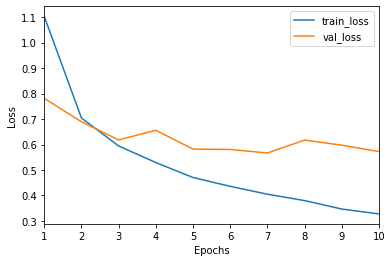

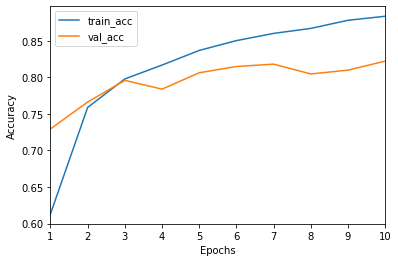

In [15]:
res_df = draw_plots(history)

In [0]:
model.save('pretrained3.h5')


In [0]:
import pandas as pd
a=pd.DataFrame.from_dict(history.history)
a.to_excel("LOG_preTrained3.xlsx") 